# Different Information Scenarios in maxent_disaggregation

This notebook demonstrates how the sampling behavior of `maxent_disagg()` changes based on the information you provide.

The `maxent_disagg()` function internally handles two key aspects:

- Sampling **share distributions** (how the total is divided)
- Sampling **aggregate distributions** (the total value)

The package uses decision trees to automatically select appropriate probability distributions based on available information:

1. For the aggregate value: The distribution choice depends on whether you provide mean, standard deviation, minimum, and maximum bounds.


<!-- ![Decision Tree Arggegate Values](../data/decision_tree_agg.png) -->

```{mermaid}
flowchart-elk TD
    %% Define node classes
    classDef decision fill:#e28743,color:black,stroke:none;
    classDef distribution fill:#abdbe3,color:black,stroke:none;
    classDef notimplementednode fill:#eeeee4,color:black,stroke:none;

    MeanDecision{{"Best guess/
    mean available?"}}:::decision
    SDDecision{{"Standard deviation available?"}}:::decision
    BoundsDecision1{{"Bounds available?"}}:::decision
    Uniform("Uniform distribution on [a,b]"):::distribution
    GoBackToStart["☠️ !Game Over!
    We suggest to rethink your problem... 🤓"]:::notimplementednode
    BoundsDecision2{{"Bounds available?"}}:::decision
    Normal("Normal distribution"):::distribution
    UnbiasedMean{{"Prefer unbiased mean?"}}:::decision
    TruncNorm("Truncated Normal 
    (Maximum Entropy distribution)"):::distribution
    LogNorm("LogNormal distribution"):::distribution
    LowerBound0{{"Lower bound = 0?"}}:::decision
    Exponential("Exponential"):::distribution
    NotImplemented["Not Implemented"]:::notimplementednode


    %% Define connections
    MeanDecision -- "no" --> BoundsDecision1
    MeanDecision -- "yes" --> SDDecision
    SDDecision -- "yes" --> BoundsDecision2
    BoundsDecision2 -- "yes" --> UnbiasedMean
    UnbiasedMean -- "yes" --> LogNorm
    UnbiasedMean -- "no" --> TruncNorm
    BoundsDecision2 -- "no" --> Normal
    SDDecision -- "no" --> LowerBound0
    LowerBound0 -- "yes" --> Exponential
    LowerBound0 -- "no" --> NotImplemented
    BoundsDecision1 -- "yes" --> Uniform
    BoundsDecision1 -- "no" --> GoBackToStart
```


2. For the shares: The distribution choice depends on whether you provide best estimates and standard deviations.

<!-- ![Decision Tree Shares](../data/decision_tree_shares.png) -->
```{mermaid}
flowchart-elk TD
    %% Define node classes
    classDef decision fill:#e28743,color:black,stroke:none;
    classDef distribution fill:#abdbe3,color:black,stroke:none;
    classDef explanationnode fill:#eeeee4,color:black,stroke:none;

    MeanDecision{{"Best guess/mean available?"}}:::decision
    SDDecision{{"Standard deviation available?"}}:::decision
    MaxEntDir("Maximum Entropy Dirichlet"):::distribution
    GenDir("Generalised Dirichlet"):::distribution
    hybridDir("Hybrid Dirichlet"):::distribution
    UniformDir("Uniform Dirichlet"):::distribution
    
    %% Define connections
    MeanDecision -- "no" --> UniformDir
    MeanDecision -- "yes" --> SDDecision
    MeanDecision -- "paritially" --> hybridDir
    SDDecision -- "no" --> MaxEntDir
    SDDecision -- "yes" --> GenDir
    SDDecision -- "partially" --> hybridDir
```



In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from maxent_disaggregation import maxent_disagg, plot_samples_hist, sample_aggregate, sample_shares

# Set sample size for demonstrations
N = 10000

/Users/ajakobs/Documents/code_projects/maxent_disaggregation/maxent_disaggregation/shares.py:324: SyntaxWarning: invalid escape sequence '\g'
  For each variable $$i$$ whose mean value ($$\alpha_i = \gamma_{par} \cdot share_i$$)


## Sampling Shares

The `maxent_disagg()` function samples the relative proportions that must sum to 1. The sampling method depends on what information you provide.

### Uniform Dirichlet Distribution

When no information about shares is available (using `np.nan`), the function uses a uniform Dirichlet distribution where all components are equally likely.

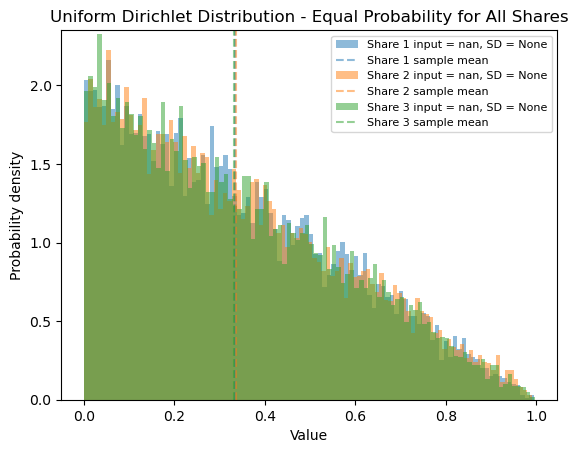

In [2]:
# Define shares with no information
shares_disaggregates = [np.nan, np.nan, np.nan]

# Sample using maxent_disagg
samples, _ = sample_shares(n=N, 
                           shares=shares_disaggregates)

# Plot the results
plot_samples_hist(samples, shares=shares_disaggregates,
                  plot_agg=False, 
                  title="Uniform Dirichlet Distribution - Equal Probability for All Shares")

### Maximum Entropy Dirichlet Distribution

When you provide best estimates for the shares but no uncertainty information, `maxent_disagg()` uses a Maximum Entropy Dirichlet distribution.

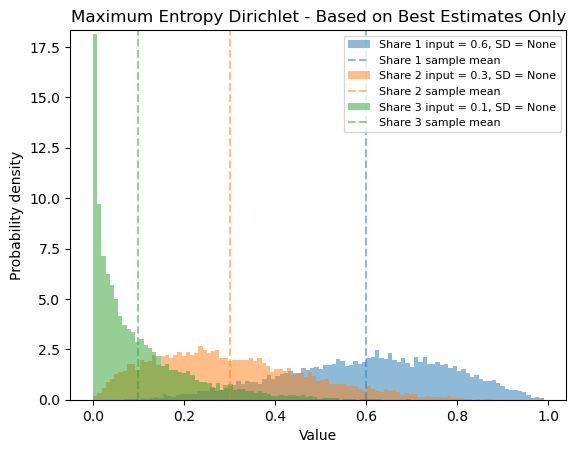

In [3]:
# Define shares with best estimates
shares_disaggregates = [0.6, 0.3, 0.1]

# Sample using maxent_disagg
samples, _ = sample_shares(n=N, 
                           shares=shares_disaggregates)

# Plot the results
plot_samples_hist(samples, shares=shares_disaggregates,
                  plot_agg=False,
                  title="Maximum Entropy Dirichlet - Based on Best Estimates Only")


### Generalized Dirichlet Distribution

When you provide both best estimates and standard deviations for the shares, `maxent_disagg()` uses a generalized Dirichlet distribution.

Sds above threshold: [1.21978671],             sds: [0.01], sample_sd: [0.02219787],             indices: [0]


/Users/ajakobs/Documents/code_projects/maxent_disaggregation/maxent_disaggregation/shares.py:434: UserWarning: The generated samples for the shares have a standard deviation that is more than 20.0% different from the specified sd's. Please note that the specified sd's might be incompetibale with the other constraints. Please check your inputs. To surpress this warning you can set a higher threshold_sd.
  warnings.warn(


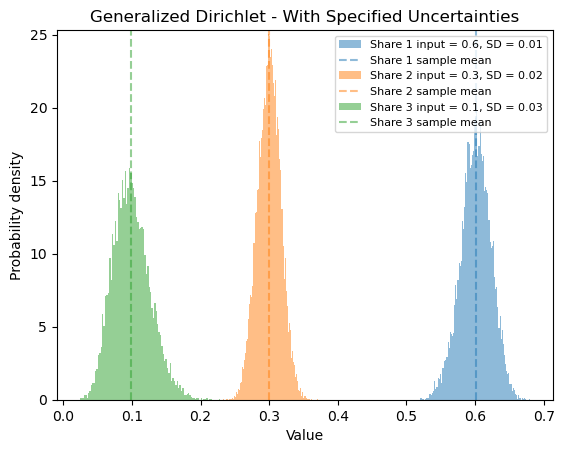

In [4]:
# Define shares with best estimates and standard deviations
shares_disaggregates = [0.6, 0.3, 0.1]
sds_shares = [0.01, 0.02, 0.03]

# Sample using maxent_disagg
samples, _ = sample_shares(n=N, 
                           shares=shares_disaggregates, 
                           sds=sds_shares)

# Plot the results
plot_samples_hist(samples, shares=shares_disaggregates,
                  sds=sds_shares,
                  plot_agg=False,
                  title="Generalized Dirichlet - With Specified Uncertainties")


### Hybrid Dirichlet Distribution

When you provide partial information on the best estimates and standard deviations for the shares, `maxent_disagg()` uses a hybrid sampling using Beta- and Maximum Entropy Dirichlet- distributions.

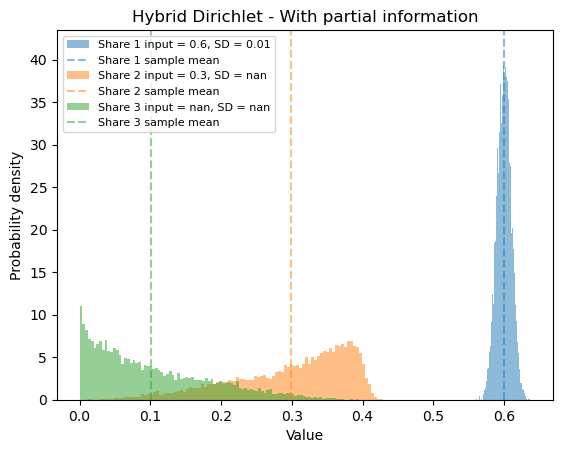

In [5]:
# Define shares with best estimates and standard deviations
shares_disaggregates = [0.6, 0.3, np.nan]
sds_shares = [0.01, np.nan, np.nan]

# Sample using maxent_disagg
samples, _ = sample_shares(n=N, 
                           shares=shares_disaggregates, 
                           sds=sds_shares)

# Plot the results
plot_samples_hist(samples, shares=shares_disaggregates,
                  sds=sds_shares,
                  plot_agg=False,
                  title="Hybrid Dirichlet - With partial information")


## Sampling the Aggregate

The `maxent_disagg()` function samples the total value to be disaggregated. Different distributions are chosen based on available information.

### Uniform Distribution

When only minimum and maximum bounds are provided:

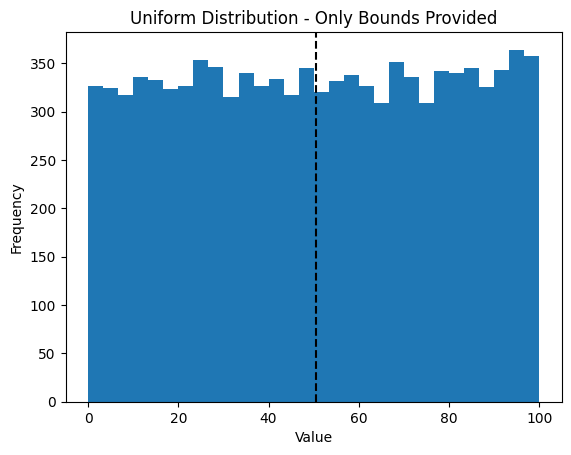

In [6]:
# Sample aggregate using uniform distribution
sample = sample_aggregate(n=N,
                           low_bound=0, 
                           high_bound=100,)

# Plot the results
plt.hist(sample, bins=30)
plt.axvline(sample.mean(), ls='--', color='k')
plt.title("Uniform Distribution - Only Bounds Provided")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

## Exponential Distribution

When a mean but no standard deviation are provided and the low_bound = 0 and upper_bound=np.inf or None

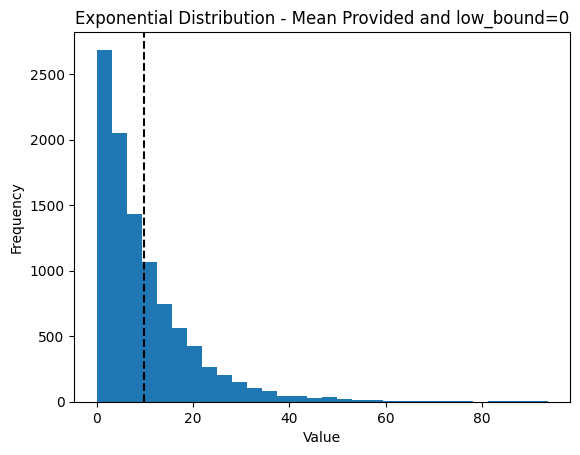

In [7]:
# Sample aggregate using exponential distribution
sample = sample_aggregate(n=N, 
                          mean=10, 
                          low_bound=0,
                          )  
# Plot the results
plt.hist(sample, bins=30)
plt.axvline(sample.mean(), ls='--', color='k')
plt.title("Exponential Distribution - Mean Provided and low_bound=0")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

### Normal Distribution

When a mean and standard deviation are provided:

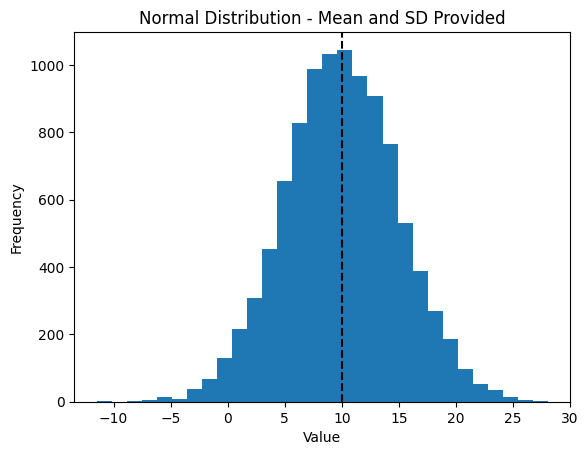

In [8]:
# Sample aggregate using normal distribution
sample = sample_aggregate(n=N, 
                          mean=10, 
                          sd = 5,
                          low_bound=-np.inf, # default is 0 so set to -inf or None to use normal distribution
                          )

# Plot the results
plt.hist(sample, bins=30)
plt.axvline(sample.mean(), ls='--', color='k')
plt.title("Normal Distribution - Mean and SD Provided")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

### Truncated Normal Distribution

For non-negative variables, you can set a lower bound of zero.

NOTE: As the truncated normal distribution causes a biased mean, see plot below. Therefore the default behaviour of
the ```maxent_disaggregation``` package is to use a lognormal distribution instead. To force the use of the truncated normal set
the flag `log=False`.


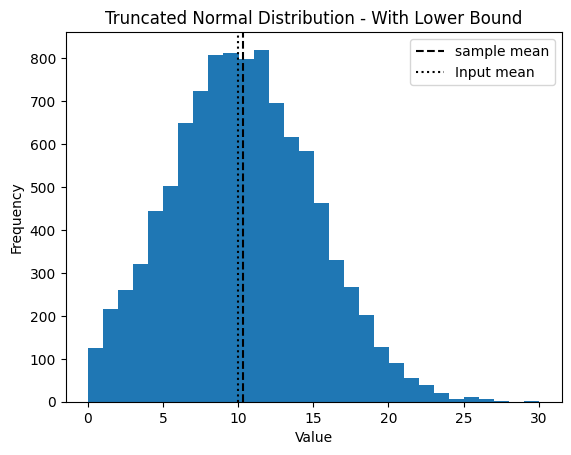

In [9]:
# Sample aggregate using truncated normal distribution
sample = sample_aggregate(n=N, 
                          mean=10, 
                          sd = 5,
                          low_bound=0,
                          log=False,  # Set to False to sample from the truncated normal distribution
                          ) 

# Plot the results
plt.hist(sample, bins=30)
plt.axvline(sample.mean(), ls='--', color='k', label="sample mean")
plt.axvline(10, ls=':', color='k', label='Input mean')
plt.legend()
plt.title("Truncated Normal Distribution - With Lower Bound")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

### Lognormal Distribution

An alternative approach for non-negative variables is using a lognormal distribution:

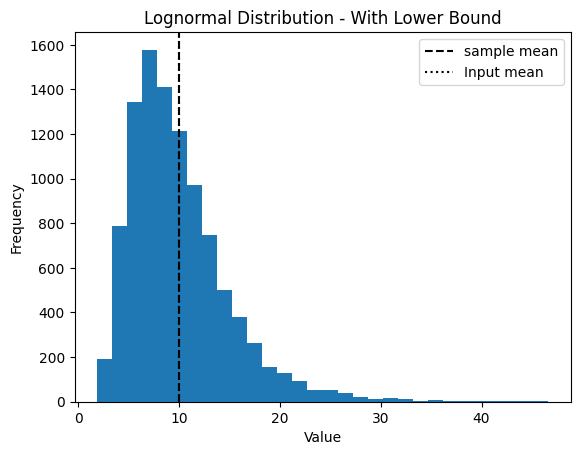

In [10]:
# Sample aggregate using lognormal distribution
sample = sample_aggregate(n=N, 
                          mean=10, 
                          sd = 5,
                          low_bound=0,
                          log=True,
                          )

# Plot the results
plt.hist(sample, bins=30)
plt.axvline(sample.mean(), ls='--', color='k', label="sample mean")
plt.axvline(10, ls=':', color='k', label='Input mean')
plt.legend()
plt.title("Lognormal Distribution - With Lower Bound")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

## Conclusion

The `maxent_disaggregation` package automatically selects appropriate distributions based on the information you provide:

1. For shares:
   - No information → Uniform Dirichlet
   - Best estimates only → Maximum Entropy Dirichlet
   - Best estimates with SDs → Generalized Dirichlet

2. For aggregates:
   - Min/max only → Uniform
   - Mean/SD only → Normal
   - Mean with min=0 → Exponential
   - Mean/SD with min/max → Truncated Normal
   - Mean/SD with log=True (Default) → Lognormal

This flexibility allows you to incorporate the precise level of information you have available while ensuring statistically valid disaggregation.